<a href="https://colab.research.google.com/github/nancyma07z/pneumonia-detection-project/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional neural network-based analysis of pediatric chest X-ray images for pneumonia detection**

This Colab notebook is designed to facilitate the training and evaluation of convolutional neural network models for the detection of pneumonia from [pediatric chest X-ray images](https://doi.org/10.17632/rscbjbr9sj.2). Utilizing TensorFlow and Keras, we define and train three different models: a basic Multilayer Perceptron (MLP), a standard VGG16, and a custom-adapted VGG16 model with enhanced dropout for better generalization. The process includes steps for data loading, preprocessing, model training, performance visualization, and statistical evaluation to compare model efficacies. By running this notebook, you will gain insights into applying deep learning techniques in medical image analysis, specifically aimed at improving diagnostic processes in pediatric healthcare.

Authors: Yilou Ma and Ricardo A. Gonzales

# 1. Environment Setup and Data Loading
Start by mounting your Google Drive to access the pediatric chest X-ray dataset. This step ensures that the Google Colab session can interact with the files stored in your Google Drive.

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.metrics import f1_score, accuracy_score

# 2. Data Preparation
Define a function to handle the creation of training and validation datasets. Utilize TensorFlow's image_dataset_from_directory to automatically label images based on their folder structure, perform basic image preprocessing like resizing and converting to grayscale, and manage the split between training and validation data. This function will streamline the process of preparing your data for model training.

In [ ]:
def get_tf_data(data_path, batch_size, img_size, seed, split):
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      labels="inferred",
      label_mode="binary",
      color_mode="grayscale",
      batch_size=batch_size,
      image_size=(img_size[0], img_size[1]),
      shuffle=True,
      seed=seed,
      validation_split=split,
      subset="training",
      interpolation="bilinear",
      crop_to_aspect_ratio=True)
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      labels="inferred",
      label_mode="binary",
      color_mode="grayscale",
      batch_size=batch_size,
      image_size=(img_size[0], img_size[1]),
      shuffle=True,
      seed=seed,
      validation_split=split,
      subset="validation",
      interpolation="bilinear",
      crop_to_aspect_ratio=True
      )
  # Additional recommendable settings
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return train_ds, val_ds

Helper functions

In [ ]:
def plot_history(model_history):
  plt.figure(figsize=(5, 10))
  plt.subplot(2, 1, 1)
  plt.plot(model_history.history['loss'], label='training loss')
  plt.plot(model_history.history['val_loss'], label='validation loss')
  plt.xlabel('epochs', fontsize=16)
  plt.ylabel('loss', fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.subplot(2, 1, 2)
  plt.plot(model_history.history['accuracy'], label='training accuracy')
  plt.plot(model_history.history['val_accuracy'], label='validation accuracy')
  plt.xlabel('epochs', fontsize=16)
  plt.ylabel('accuracy', fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()

In [ ]:
def get_y_true_and_y_preds(dataset, model_1, model_2, model_3):
  y_true_list = []
  y_pred_1_list = []
  y_pred_2_list = []
  y_pred_3_list = []
  for batch in dataset:
    x, y_true = batch
    y_pred_1 = model_1.predict(x, verbose=0)
    y_pred_2 = model_2.predict(x, verbose=0)
    y_pred_3 = model_3.predict(x, verbose=0)
    y_true_list.append(y_true.numpy())
    y_pred_1_list.append(y_pred_1)
    y_pred_2_list.append(y_pred_2)
    y_pred_3_list.append(y_pred_3)
  y_true = np.concatenate(y_true_list)
  y_pred_1 = np.concatenate(y_pred_1_list).squeeze()
  y_pred_1 = (y_pred_1 >= 0.5).astype('int64')
  y_pred_2 = np.concatenate(y_pred_2_list).squeeze()
  y_pred_2 = (y_pred_2 >= 0.5).astype('int64')
  y_pred_3 = np.concatenate(y_pred_3_list).squeeze()
  y_pred_3 = (y_pred_3 >= 0.5).astype('int64')
  return y_true, y_pred_1, y_pred_2, y_pred_3

In [ ]:
def chi2_contingency_test(y_true, y_pred_a, y_pred_b):
  tb = np.array([[np.sum((y_pred_a == y_true) & (y_pred_b == y_true)),
                np.sum((y_pred_a == y_true) & (y_pred_b != y_true))],
               [np.sum((y_pred_a != y_true) & (y_pred_b == y_true)),
                np.sum((y_pred_a != y_true) & (y_pred_b != y_true))]])
  chi2, p = chi2_contingency(tb, correction=False)[:2]
  return chi2, p

# 3. Data, Model Definitions and Training
Outline the architecture for three neural network models:

- A basic Artificial Neural Network (ANN) with several dense layers.
- A standard VGG16 model with multiple convolutional and max pooling layers for deeper feature extraction.
- A custom adaptation of the VGG16 model, incorporating dropout layers to reduce overfitting and adjusting filter sizes for optimized performance.

Compile and train each model using the Adam optimizer and binary cross-entropy as the loss function. Execute the training over 100 epochs, monitoring both training and validation metrics to gauge the models' performance.

In [ ]:
data_path = "/content/drive/MyDrive/Veritas AI/Veritas AI - Nancy/data/chest_xray"
print(len(os.listdir(os.path.join(data_path, 'normal'))))
print(len(os.listdir(os.path.join(data_path, 'pneumonia'))))

1583
4273


In [ ]:
batch_size = 32
img_size = (128, 128, 1)
seed = 42
split = 0.2
train_ds, val_ds = get_tf_data(data_path, batch_size, img_size, seed, split)

Found 5856 files belonging to 2 classes.
Using 4685 files for training.
Found 5856 files belonging to 2 classes.
Using 1171 files for validation.


In [ ]:
ANN = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=img_size),
    tf.keras.layers.RandomZoom(0.3, fill_mode='constant', fill_value=0.0),
    tf.keras.layers.RandomRotation(0.1, fill_mode='constant', fill_value=0.0),
    tf.keras.layers.RandomBrightness(0.1, value_range=[0.0, 1.0]),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
ANN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
ANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 1)       0         
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 1)       0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 128, 128, 1)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 128, 128, 1)       0         
 trast)                                                          
                                                        

In [ ]:
ANN_history = ANN.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=100)

Epoch 1/100
147/147 [==============================] - 443s 438ms/step - loss: 0.4974 - accuracy: 0.7712 - val_loss: 0.3257 - val_accuracy: 0.8386
Epoch 2/100
147/147 [==============================] - 1s 8ms/step - loss: 0.3873 - accuracy: 0.8352 - val_loss: 0.5067 - val_accuracy: 0.7652
Epoch 3/100
147/147 [==============================] - 1s 9ms/step - loss: 0.3507 - accuracy: 0.8495 - val_loss: 0.6332 - val_accuracy: 0.7054
Epoch 4/100
147/147 [==============================] - 2s 14ms/step - loss: 0.3395 - accuracy: 0.8487 - val_loss: 0.4621 - val_accuracy: 0.7899
Epoch 5/100
147/147 [==============================] - 3s 17ms/step - loss: 0.3559 - accuracy: 0.8470 - val_loss: 0.3083 - val_accuracy: 0.8557
Epoch 6/100
147/147 [==============================] - 1s 8ms/step - loss: 0.3325 - accuracy: 0.8630 - val_loss: 0.3516 - val_accuracy: 0.8523
Epoch 7/100
147/147 [==============================] - 1s 8ms/step - loss: 0.3370 - accuracy: 0.8566 - val_loss: 0.4264 - val_accuracy: 

In [ ]:
VGG16 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=img_size),
    tf.keras.layers.RandomZoom(0.3, fill_mode='constant', fill_value=0.0),
    tf.keras.layers.RandomRotation(0.1, fill_mode='constant', fill_value=0.0),
    tf.keras.layers.RandomBrightness(0.1, value_range=[0.0, 1.0]),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 128, 128, 1)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 128, 128, 1)       0         
 otation)                                                        
                                                                 
 random_brightness_1 (Rando  (None, 128, 128, 1)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_1 (RandomC  (None, 128, 128, 1)       0         
 ontrast)                                                        
                                                      

In [ ]:
VGG16_history = VGG16.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=100)

Epoch 1/100
147/147 [==============================] - 48s 211ms/step - loss: 0.5457 - accuracy: 0.7390 - val_loss: 0.6199 - val_accuracy: 0.5850
Epoch 2/100
147/147 [==============================] - 25s 170ms/step - loss: 0.3698 - accuracy: 0.8412 - val_loss: 0.8825 - val_accuracy: 0.4962
Epoch 3/100
147/147 [==============================] - 24s 166ms/step - loss: 0.3105 - accuracy: 0.8692 - val_loss: 0.9267 - val_accuracy: 0.6652
Epoch 4/100
147/147 [==============================] - 25s 173ms/step - loss: 0.2945 - accuracy: 0.8747 - val_loss: 0.4064 - val_accuracy: 0.8437
Epoch 5/100
147/147 [==============================] - 25s 171ms/step - loss: 0.2740 - accuracy: 0.8864 - val_loss: 0.6783 - val_accuracy: 0.7079
Epoch 6/100
147/147 [==============================] - 26s 174ms/step - loss: 0.2412 - accuracy: 0.8988 - val_loss: 0.2935 - val_accuracy: 0.8822
Epoch 7/100
147/147 [==============================] - 24s 160ms/step - loss: 0.2044 - accuracy: 0.9210 - val_loss: 0.3484 -

In [ ]:
model=tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=img_size),
    tf.keras.layers.RandomZoom(0.3, fill_mode='constant', fill_value=0.0),
    tf.keras.layers.RandomRotation(0.1, fill_mode='constant', fill_value=0.0),
    tf.keras.layers.RandomBrightness(0.1, value_range=[0.0, 1.0]),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 128, 128, 1)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 128, 128, 1)       0         
 otation)                                                        
                                                                 
 random_brightness_2 (Rando  (None, 128, 128, 1)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_2 (RandomC  (None, 128, 128, 1)       0         
 ontrast)                                                        
                                                      

In [ ]:
model_history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=100)

Epoch 1/100
147/147 [==============================] - 26s 103ms/step - loss: 0.5982 - accuracy: 0.7208 - val_loss: 0.6741 - val_accuracy: 0.7583
Epoch 2/100
147/147 [==============================] - 12s 81ms/step - loss: 0.6018 - accuracy: 0.7225 - val_loss: 0.5725 - val_accuracy: 0.7583
Epoch 3/100
147/147 [==============================] - 12s 80ms/step - loss: 0.4647 - accuracy: 0.7695 - val_loss: 0.5526 - val_accuracy: 0.8804
Epoch 4/100
147/147 [==============================] - 12s 80ms/step - loss: 0.3797 - accuracy: 0.8440 - val_loss: 0.4617 - val_accuracy: 0.8506
Epoch 5/100
147/147 [==============================] - 12s 78ms/step - loss: 0.3314 - accuracy: 0.8642 - val_loss: 0.3712 - val_accuracy: 0.8839
Epoch 6/100
147/147 [==============================] - 12s 79ms/step - loss: 0.2939 - accuracy: 0.8843 - val_loss: 0.3836 - val_accuracy: 0.8924
Epoch 7/100
147/147 [==============================] - 12s 79ms/step - loss: 0.2753 - accuracy: 0.8830 - val_loss: 0.3536 - val_a

#4. Performance Visualization
After training, use a custom plotting function to visually assess how the loss and accuracy of each model progressed across the epochs. This visual feedback is crucial for detecting issues like overfitting or underfitting and confirming whether the models are learning effectively from the training data.

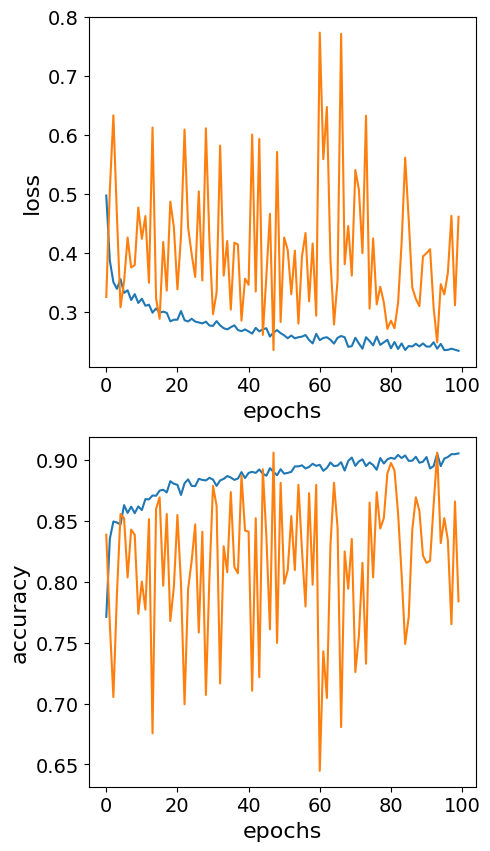

In [ ]:
plot_history(ANN_history)

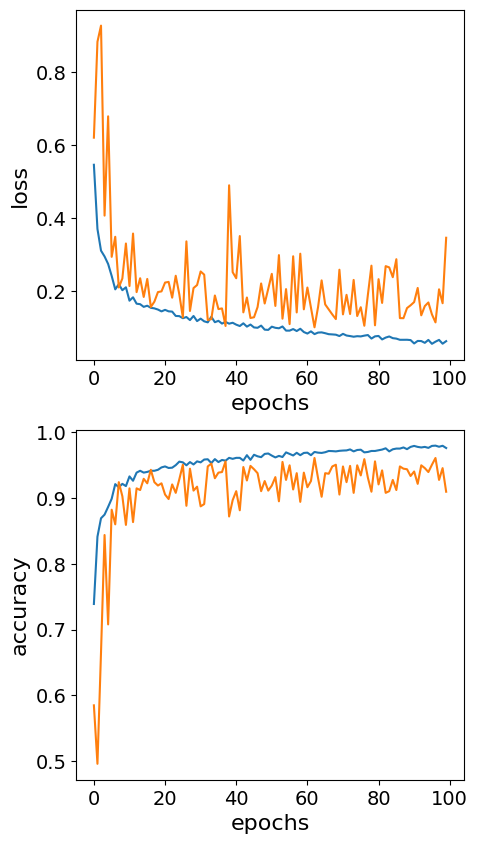

In [ ]:
plot_history(VGG16_history)

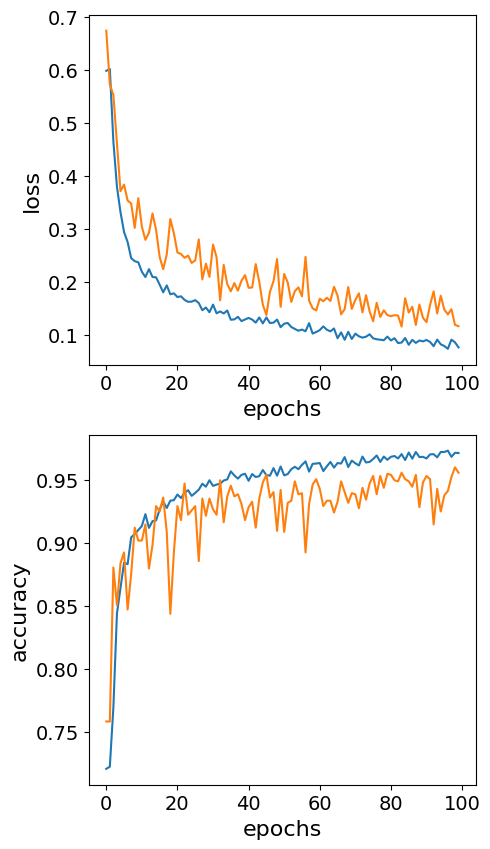

In [ ]:
plot_history(model_history)

#5. Performance Evaluation
Generate predictions for the validation dataset using the trained models and calculate accuracy and F1 scores to quantify each model's performance. Employ a chi-squared contingency test to statistically compare the performance differences between the models, providing a robust statistical basis to evaluate their effectiveness against each other.

In [ ]:
y_true, y_pred_ANN, y_pred_VGG16, y_pred_model = get_y_true_and_y_preds(val_ds, ANN, VGG16, model)

In [ ]:
acc_ANN = accuracy_score(y_true, y_pred_ANN)
acc_VGG16 = accuracy_score(y_true, y_pred_VGG16)
acc_model = accuracy_score(y_true, y_pred_model)
print(acc_ANN, acc_VGG16, acc_model)

f1_ANN = f1_score(y_true, y_pred_ANN)
f1_VGG16 = f1_score(y_true, y_pred_VGG16)
f1_model = f1_score(y_true, y_pred_model)
print(f1_ANN, f1_VGG16, f1_model)

0.7839453458582408 0.9094790777113578 0.955593509820666
0.8358208955223881 0.936678614097969 0.970554926387316


In [ ]:
chi2_1_2, p_1_2 = chi2_contingency_test(y_true, y_pred_ANN, y_pred_VGG16)
chi2_2_3, p_2_3 = chi2_contingency_test(y_true, y_pred_VGG16, y_pred_model)
chi2_1_3, p_1_3 = chi2_contingency_test(y_true, y_pred_ANN, y_pred_model)

print(chi2_1_2, p_1_2)
print(chi2_2_3, p_2_3)
print(chi2_1_3, p_1_3)

631362.595904351 0.0
955599.1678567347 0.0
489878.9854308915 0.0


# 6. Model Saving
Finally, save each trained model to Google Drive. This step is vital for preserving your models, allowing them to be re-used for predictions or further training without the need to retrain from scratch, saving both time and computational resources.

In [ ]:
ANN.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Nancy/code/models/ANN.h5')
VGG16.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Nancy/code/models/VGG16.h5')
model.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Nancy/code/models/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
